In [84]:
import pandas as pd
import os
import librosa
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from librosa.feature import mfcc
from librosa.display import specshow

from tensorflow.keras.layers import GRU, LSTM, TimeDistributed, Input, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.activations import softmax, relu, tanh
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

import utils

import sklearn as skl

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.log_device_placement=True
sess = tf.Session(config=config)
tf.keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



In [3]:
shuffled_train = np.load('shuffled_train.npz')

In [4]:
shuffled_train.files

['arr_0', 'arr_1']

In [5]:
X = shuffled_train.get('arr_0')

In [6]:
X.shape

(6394, 640, 128)

In [7]:
y = shuffled_train.get('arr_1')

In [52]:
shuffled_val = np.load('shuffled_valid.npz')

In [53]:
valX = shuffled_val.get('arr_0')
valY = shuffled_val.get('arr_1')

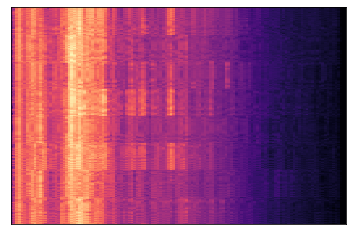

In [10]:
librosa.display.specshow(X[1])

In [66]:
def create_model():
    model = Sequential()
    #model.add(Input())
    model.add(Conv1D(64, kernel_size=3, input_shape = (640, 128), activation = 'relu'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPool1D(2))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(128, kernel_size=3, input_shape = (640, 128), activation = 'relu'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPool1D(2))
    model.add(Dropout(0.4))
    
    model.add(Conv1D(128, kernel_size=3, input_shape = (640, 128), activation = 'relu'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPool1D(2))
    model.add(Dropout(0.4))
    
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.25))
    
    model.add(Dense(8, activation='softmax'))
    return model

In [85]:
def create_model():
    model = Sequential()
    #model.add(Input())
    model.add(Conv1D(64, kernel_size=3, input_shape = (640, 128), activation = 'relu'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPool1D(2))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(128, kernel_size=3, input_shape = (640, 128), activation = 'relu'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPool1D(2))
    model.add(Dropout(0.4))
    
    model.add(Conv1D(128, kernel_size=3, input_shape = (640, 128), activation = 'relu'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPool1D(2))
    model.add(Dropout(0.4))
    
    model.add(GRU(64, return_sequences=True))
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.25))
    
    model.add(Dense(8, activation='softmax'))
    return model

In [86]:
model = create_model()

In [87]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 638, 64)           24640     
_________________________________________________________________
batch_normalization_18 (Batc (None, 638, 64)           256       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 319, 64)           0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 319, 64)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 317, 128)          24704     
_________________________________________________________________
batch_normalization_19 (Batc (None, 317, 128)          512       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 158, 128)         

In [88]:
#adam = Adam(learning_rate=)
model.compile(optimizer = 'adam', 
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [89]:
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

In [90]:
ckpt_cb = ModelCheckpoint('./models/best.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [91]:
reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
callbacks_list = [ckpt_cb, reducelr_callback]

In [83]:
hist = model.fit(X, y, batch_size = 128, epochs=70, callbacks=callbacks_list, validation_data=(valX, valY))

Train on 6394 samples, validate on 800 samples
Epoch 1/70
6272/6394 [============================>.] - ETA: 0s - loss: 1.7837 - acc: 0.3439
Epoch 00001: val_acc improved from -inf to 0.25250, saving model to ./models/best.h5
6394/6394 [==============================] - 14s 2ms/sample - loss: 1.7811 - acc: 0.3450 - val_loss: 1.9523 - val_acc: 0.2525
Epoch 2/70
6272/6394 [============================>.] - ETA: 0s - loss: 1.6445 - acc: 0.3992
Epoch 00002: val_acc improved from 0.25250 to 0.30250, saving model to ./models/best.h5
6394/6394 [==============================] - 10s 2ms/sample - loss: 1.6435 - acc: 0.3994 - val_loss: 1.7669 - val_acc: 0.3025
Epoch 3/70
6272/6394 [============================>.] - ETA: 0s - loss: 1.5759 - acc: 0.4322
Epoch 00003: val_acc did not improve from 0.30250
6394/6394 [==============================] - 10s 2ms/sample - loss: 1.5762 - acc: 0.4323 - val_loss: 1.8713 - val_acc: 0.2750
Epoch 4/70
6272/6394 [============================>.] - ETA: 0s - loss: 1

6272/6394 [============================>.] - ETA: 0s - loss: 1.1474 - acc: 0.6073
Epoch 00030: val_acc did not improve from 0.45125
6394/6394 [==============================] - 10s 2ms/sample - loss: 1.1435 - acc: 0.6089 - val_loss: 1.6857 - val_acc: 0.4137
Epoch 31/70
6272/6394 [============================>.] - ETA: 0s - loss: 1.1190 - acc: 0.6196
Epoch 00031: val_acc did not improve from 0.45125
6394/6394 [==============================] - 10s 2ms/sample - loss: 1.1208 - acc: 0.6192 - val_loss: 1.8836 - val_acc: 0.3825
Epoch 32/70
6272/6394 [============================>.] - ETA: 0s - loss: 1.1289 - acc: 0.6110
Epoch 00032: val_acc did not improve from 0.45125

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
6394/6394 [==============================] - 10s 2ms/sample - loss: 1.1279 - acc: 0.6106 - val_loss: 1.7404 - val_acc: 0.4038
Epoch 33/70
6272/6394 [============================>.] - ETA: 0s - loss: 1.0920 - acc: 0.6283
Epoch 00033: val_acc did no

6272/6394 [============================>.] - ETA: 0s - loss: 0.9309 - acc: 0.6857
Epoch 00059: val_acc did not improve from 0.45875
6394/6394 [==============================] - 10s 2ms/sample - loss: 0.9311 - acc: 0.6861 - val_loss: 1.6966 - val_acc: 0.4288
Epoch 60/70
6272/6394 [============================>.] - ETA: 0s - loss: 0.9209 - acc: 0.6897
Epoch 00060: val_acc did not improve from 0.45875
6394/6394 [==============================] - 10s 2ms/sample - loss: 0.9217 - acc: 0.6892 - val_loss: 1.7357 - val_acc: 0.4238
Epoch 61/70
6272/6394 [============================>.] - ETA: 0s - loss: 0.9132 - acc: 0.6963- ETA: 1s - loss: 0.9080 - acc: 0
Epoch 00061: val_acc did not improve from 0.45875
6394/6394 [==============================] - 10s 2ms/sample - loss: 0.9120 - acc: 0.6964 - val_loss: 1.7484 - val_acc: 0.4238
Epoch 62/70
6272/6394 [============================>.] - ETA: 0s - loss: 0.9147 - acc: 0.6940
Epoch 00062: val_acc did not improve from 0.45875

Epoch 00062: ReduceLROnP

In [ ]:
hist = model.fit(X, y, batch_size = 32, epochs=70, callbacks=callbacks_list, validation_data=(valX, valY))

Train on 6394 samples, validate on 800 samples
Epoch 1/70
6368/6394 [============================>.] - ETA: 0s - loss: 1.8318 - acc: 0.3147
Epoch 00001: val_acc improved from -inf to 0.30125, saving model to ./models/best.h5
6394/6394 [==============================] - 32s 5ms/sample - loss: 1.8302 - acc: 0.3155 - val_loss: 1.8746 - val_acc: 0.3013
Epoch 2/70
6368/6394 [============================>.] - ETA: 0s - loss: 1.7069 - acc: 0.3747
Epoch 00002: val_acc did not improve from 0.30125
6394/6394 [==============================] - 28s 4ms/sample - loss: 1.7070 - acc: 0.3744 - val_loss: 2.0469 - val_acc: 0.2875
Epoch 3/70
6368/6394 [============================>.] - ETA: 0s - loss: 1.6484 - acc: 0.4023
Epoch 00003: val_acc improved from 0.30125 to 0.34875, saving model to ./models/best.h5
6394/6394 [==============================] - 28s 4ms/sample - loss: 1.6481 - acc: 0.4026 - val_loss: 1.8158 - val_acc: 0.3487
Epoch 4/70
6368/6394 [============================>.] - ETA: 0s - loss: 1

Epoch 30/70
6368/6394 [============================>.] - ETA: 0s - loss: 1.0326 - acc: 0.6424
Epoch 00030: val_acc improved from 0.51750 to 0.53000, saving model to ./models/best.h5
6394/6394 [==============================] - 27s 4ms/sample - loss: 1.0334 - acc: 0.6423 - val_loss: 1.4809 - val_acc: 0.5300
Epoch 31/70
6368/6394 [============================>.] - ETA: 0s - loss: 1.0402 - acc: 0.6383
Epoch 00031: val_acc did not improve from 0.53000
6394/6394 [==============================] - 27s 4ms/sample - loss: 1.0396 - acc: 0.6386 - val_loss: 1.5584 - val_acc: 0.4900
Epoch 32/70
6368/6394 [============================>.] - ETA: 0s - loss: 1.0413 - acc: 0.6371
Epoch 00032: val_acc did not improve from 0.53000
6394/6394 [==============================] - 28s 4ms/sample - loss: 1.0405 - acc: 0.6372 - val_loss: 1.5092 - val_acc: 0.5138
Epoch 33/70
3072/6394 [=============>................] - ETA: 13s - loss: 1.0252 - acc: 0.6442

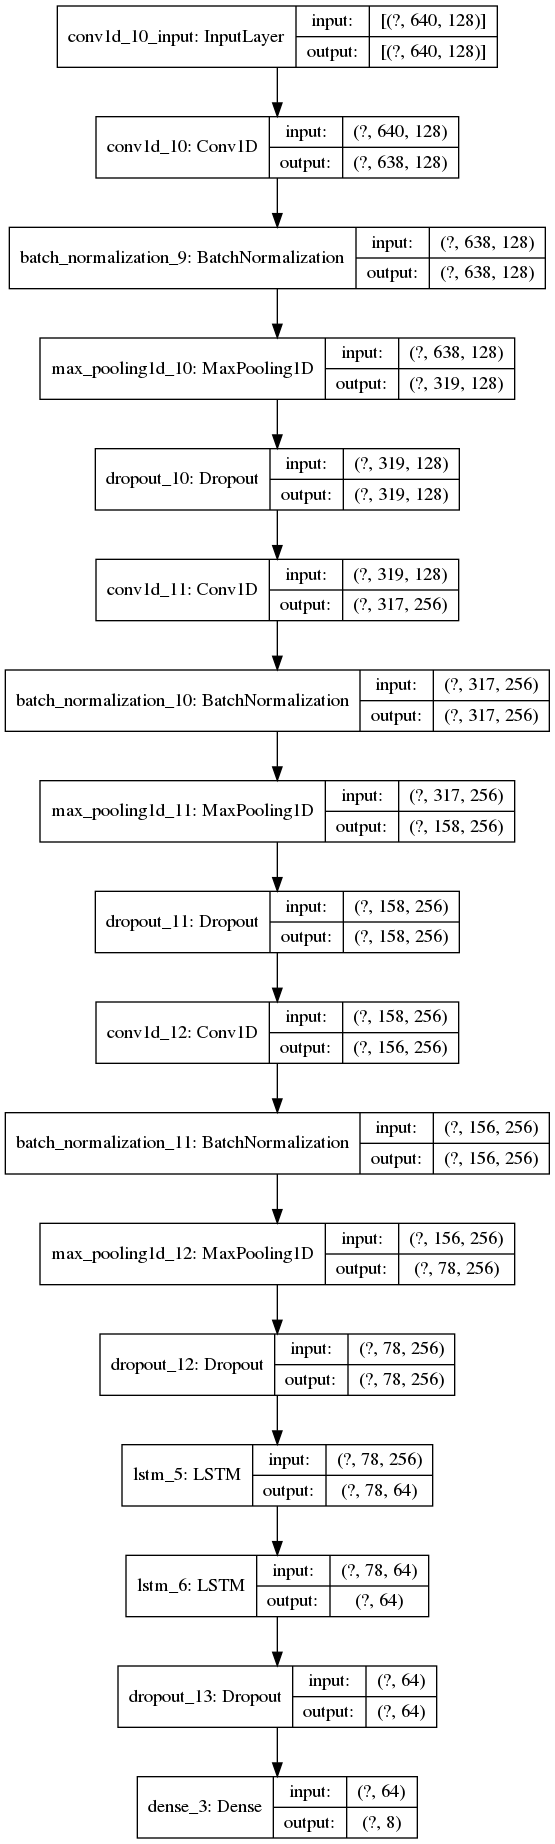

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


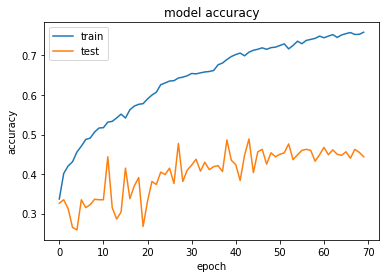

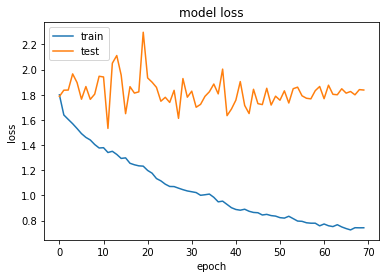

In [74]:
    # List all data in history
    print(hist.history.keys())

    # Summarize history for accuracy
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()